# Задача:
Проанализируйте клиентов регионального банка и сегментируйте пользователей по количеству потребляемых продуктов.

## Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
def basic_info(data):
    data.columns = data.columns.str.lower()
    print ('\033[1m' + 'Вывод метода info()' + '\033[0m')
    print(data.info())
    print ('\033[1m' + 'Вывод метода describe()' + '\033[0m')
    display(data.describe())
    print ('\033[1m' + 'Дубликаты' + '\033[0m')
    display(data.duplicated().sum())
    display(data.head(10))
    print ('\033[1m' + 'Пропуски в таблице' + '\033[0m')
    display(pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    
basic_info(data)

Вывод метода info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
city                10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
objects             10000 non-null int64
balance             6383 non-null float64
products            10000 non-null int64
creditcard          10000 non-null int64
loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
Вывод метода describe()


,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Дубликаты


0

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Пропуски в таблице


,0
userid,0
score,0
city,0
gender,0
age,0
objects,0
balance,36.17
products,0
creditcard,0
loyalty,0


### Выводы:
- Есть пропущенные значения в столбце balance, нужно выяснить причину отсутствия и подумать над заполнением;
- В двух столбцах ('city' и 'gender') можно изменить тип данных, чтобы они смогли участвовать в кластеризации;

<div class='alert alert-success'>
Отличное начало, рад что тебе удалось разобраться с расположением данных на сервере!

## Шаг 2. Исследовательский анализ данных (EDA)

### Немного переработаем данные в столбцах 'city', 'gender' и 'balance'

Первым делом превратим строковые значения в столбцах с городами и полом в числа

In [4]:
data

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1


from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = data['gender'])
x = onehotencoder.fit_transform(data['city']).toarray()

In [5]:
city = pd.Series(data.city)
cities_separate = pd.get_dummies(city)
gender = pd.Series(data.gender)
gender_separate = pd.get_dummies(gender)

In [6]:
data = pd.merge(
    left=data,
    right=cities_separate,
    left_index=True,
    right_index=True,
)

In [7]:
data = pd.merge(
    left=data,
    right=gender_separate,
    left_index=True,
    right_index=True,
)

In [8]:
data['city'] = np.where((data['city'] == 'Ярославль'), 0, data['city'])
data['city'] = np.where((data['city'] == 'Рыбинск'), 1, data['city'])
data['city'] = np.where((data['city'] == 'Ростов Великий'), 2, data['city'])
data['gender'] = np.where((data['gender'] == 'Ж'), 0, data['gender'])
data['gender'] = np.where((data['gender'] == 'М'), 1, data['gender'])
data['city'] = data['city'].astype('int')
data['gender'] = data['gender'].astype('int')

In [9]:
data

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
0,15677338,619,0,0,42,2,NaN,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,1,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,0,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,0,0,39,1,NaN,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,1,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,0,1,39,5,NaN,2,1,0,96270.64,0,0,0,1,0,1
9996,15612628,516,0,1,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,15627268,709,0,0,36,7,NaN,1,0,1,42085.58,1,0,0,1,1,0
9998,15725091,772,2,1,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


<div class='alert alert-warning'>
Для данной кодировки используется label_encoder из sklearn, также не понято почему городам даны такие странные значения ? Города лучше кодировать либо с помощью порядковой кодировки либо с помощью onehot – зависит от цели= ипсользования

<div class="alert alert-block alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Сделал :) Всё равно перевёл столбцы city и gender, так как потом проще группировать, но в heatmap использовал новые столбцы.</div>

Давайте разберёмся со значениями в столбце 'balance'

In [10]:
data_nan = data[(data['balance'].isna())]
data_nan

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
0,15677338,619,0,0,42,2,NaN,1,1,1,101348.88,1,0,0,1,1,0
3,15744090,699,0,0,39,1,NaN,2,0,0,93826.63,0,0,0,1,1,0
6,15635267,822,0,1,50,7,NaN,2,1,1,10062.80,0,0,0,1,0,1
11,15779909,497,1,1,24,3,NaN,2,1,0,76390.01,0,0,1,0,0,1
12,15675000,476,0,0,34,10,NaN,2,1,0,26260.98,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,1,1,28,4,NaN,2,1,1,179436.60,0,0,1,0,0,1
9992,15699841,726,1,1,36,2,NaN,1,1,0,195192.40,0,0,1,0,0,1
9994,15762030,800,0,0,29,2,NaN,2,0,0,167773.55,0,0,0,1,1,0
9995,15648965,771,0,1,39,5,NaN,2,1,0,96270.64,0,0,0,1,0,1


In [11]:
data_not_nan = data[~(data['balance'].isna())]
data_not_nan 

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
1,15690047,608,1,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,0,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
4,15780624,850,1,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
5,15616748,645,1,1,44,8,113755.78,2,1,0,149756.71,1,0,1,0,0,1
7,15698884,376,2,0,29,4,115046.74,4,1,0,119346.88,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,15812695,597,0,0,53,4,88381.21,1,1,0,69384.71,1,0,0,1,1,0
9993,15612002,644,0,1,28,7,155060.41,1,1,0,29179.52,0,0,0,1,0,1
9996,15612628,516,0,1,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9998,15725091,772,2,1,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


In [12]:
data_nan.describe()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
count,3.617000e+03,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.0,3617.000000,3617.000000,3617.000000,3617.000000
mean,1.573469e+07,649.452861,0.331490,0.542715,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236,0.0,0.331490,0.668510,0.457285,0.542715
std,7.194749e+04,96.158798,0.470814,0.498241,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195,0.0,0.470814,0.470814,0.498241,0.498241
min,1.560844e+07,350.000000,0.000000,0.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.567226e+07,583.000000,0.000000,0.000000,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.573608e+07,651.000000,0.000000,1.000000,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000
75%,1.579629e+07,717.000000,1.000000,1.000000,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,1.585810e+07,850.000000,1.000000,1.000000,88.000000,10.000000,NaN,4.000000,1.000000,1.000000,199992.480000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [13]:
data_not_nan.describe()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
count,6.383000e+03,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000
mean,1.573310e+07,651.138493,0.986370,0.547392,39.197713,4.979633,119827.493793,1.386025,0.699201,0.513552,100717.352956,0.240796,0.393075,0.200219,0.406705,0.452608,0.547392
std,7.192913e+04,96.934609,0.894271,0.497788,10.476208,2.909514,30095.056462,0.577011,0.458641,0.499855,57380.316584,0.427600,0.488472,0.400196,0.491257,0.497788,0.497788
min,1.560844e+07,350.000000,0.000000,0.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567094e+07,584.000000,0.000000,0.000000,32.000000,2.000000,100181.975000,1.000000,0.000000,0.000000,51736.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573226e+07,652.000000,1.000000,1.000000,38.000000,5.000000,119839.690000,1.000000,1.000000,1.000000,101139.300000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.579584e+07,718.000000,2.000000,1.000000,44.000000,8.000000,139512.290000,2.000000,1.000000,1.000000,149596.615000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585843e+07,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Треть пропущенных значений - это огромное количество. Сравнив две выборки (есть значения и нет) я не увидел в них особой разницы. 
С трудом себе представляю, чтобы эта проблема была вызвана каким-то сбоем при выгрузке данных. Не вижу логической возможности заменить пустые значения каким-то образом, поэтому давайте просто заменим их на 0, считая, что у этих людей просто нет средств на счёте.

In [14]:
data = data.fillna(0)

### Посмотрим на средние значения признаков исходя из количества потребляемых продуктов

Выделим 4 группы по количеству продуктов, которыми пользуются пользователи; номер группы равен количеству продуктов.

In [15]:
data_mean = data.groupby('products', as_index = False).mean().T
data_mean = data_mean.drop('products').rename(columns={0: 1, 1: 2, 2: 3, 3: 4})
data_mean

,1,2,3,4
userid,1.573237e+07,1.573484e+07,1.574182e+07,1.571936e+07
score,6.491210e+02,6.521887e+02,6.481053e+02,6.535833e+02
city,7.708497e-01,7.108932e-01,9.699248e-01,9.166667e-01
gender,5.483871e-01,5.511983e-01,4.398496e-01,3.666667e-01
age,3.967309e+01,3.775359e+01,4.319549e+01,4.568333e+01
objects,4.974626e+00,5.051852e+00,5.003759e+00,5.300000e+00
balance,9.855187e+04,5.187915e+04,7.545833e+04,9.373314e+04
creditcard,7.037766e-01,7.071895e-01,7.142857e-01,6.833333e-01
loyalty,5.041306e-01,5.328976e-01,4.248120e-01,4.833333e-01
estimated_salary,9.948726e+04,1.004520e+05,1.043181e+05,1.047637e+05


<div class='alert alert-success'>
Кстати такой вид переименования можно сделать с помощью генератора. Пример ниже

In [16]:
# Пример
{i: i + 1 for i in range(4)}

{0: 1, 1: 2, 2: 3, 3: 4}

In [17]:
data_std = data.groupby('products', as_index = False).std().T
data_std = data_std.drop('products').rename(columns={0: 1, 1: 2, 2: 3, 3: 4})
data_std

,1,2,3,4
userid,72165.780479,71565.420386,73952.793849,68148.400931
score,97.203710,96.066831,95.190396,101.265600
city,0.841109,0.811681,0.868222,0.944057
gender,0.497702,0.497426,0.497304,0.485961
age,10.659566,10.145663,10.422008,8.619040
objects,2.914269,2.867741,2.879332,2.947564
balance,53234.092790,62644.474506,62924.623833,57507.383750
creditcard,0.456636,0.455102,0.452606,0.469102
loyalty,0.500032,0.498971,0.495246,0.503939
estimated_salary,57363.626412,57790.799984,55464.281426,57526.494114


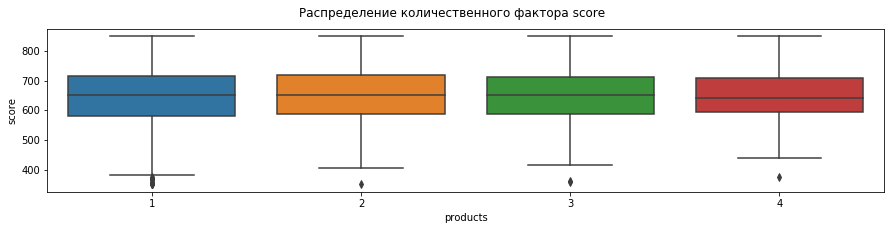

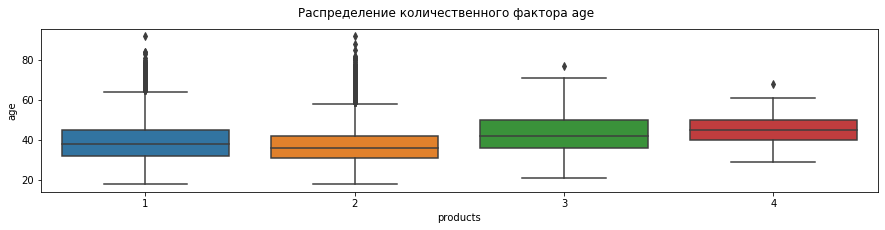

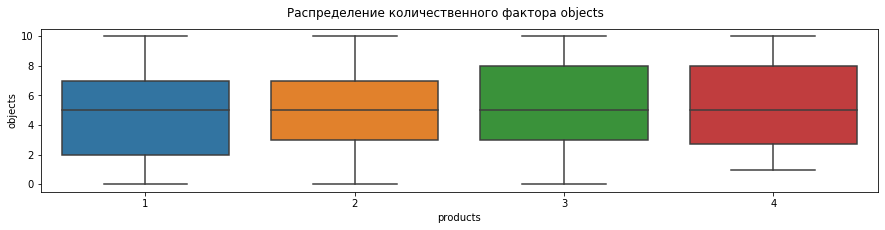

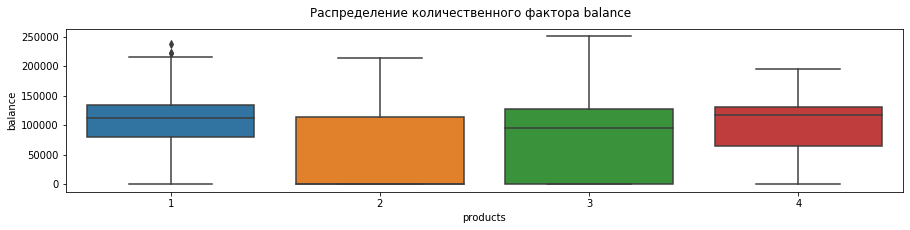

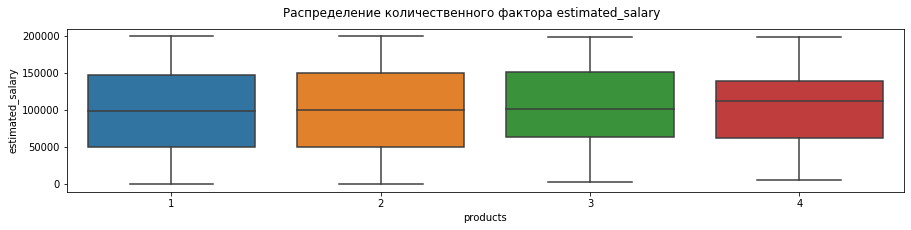

In [18]:
columns = ['score', 'age', 'objects', 'balance', 'estimated_salary']

for i in columns:
    plt.figure(figsize=(15, 3))
    sns.boxplot(data=data, x='products', y=i)
    plt.suptitle('Распределение количественного фактора ' + i)
    plt.show()

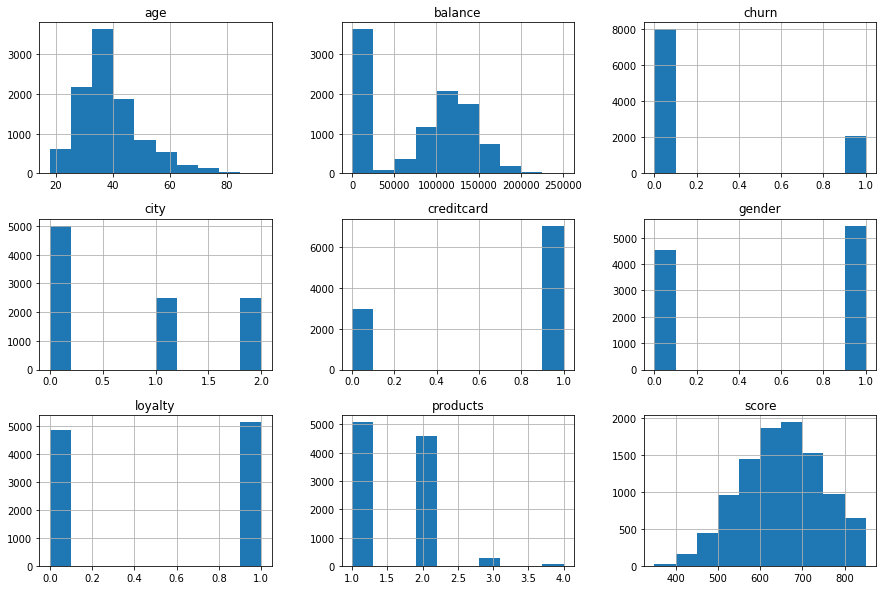

In [19]:
features = list(set(['city','gender', 'creditcard', 'loyalty', 'churn', 'products', 'age', 'balance', 'score']))

data[features].hist(figsize=(15,10));

#### Выводы:
- Показатели кредитного скоринга во всех 4-х групп примерно одинаковые, хотя в 1-й группе больше выбросов, чем в остальных;
- Возраст сильно отличается во всех группах: в первой и второй он заметно ниже, чем в 3-й и 4-й;
- Если среднее количество объектов у всех групп одинаковое, то разброс значений показывает небольшое расхождение:
-- В 4-й группе у каждого пользователя есть как минимум один объект в пользовании;
-- В 1-й группе диапазон значений в среднем соответствует 2-7 объекта, когда как в других группах 3-7 и 3-8 объекта.
- Предполагаемая зарплата в каждой группе примерно одинаковая;
- А вот баланс на карте показывает самые сильные различия между группами:
-- Всех пользователей можно разделить на 2 подгруппы:
-- - В первой будут группы 1 и 4, для которых характерно наличие в среднем 125000 Р на карте; при этом людей с 0 балансом мало;
-- - Во второй будут группы 2 и 3, в которых у значительного количества пользователей нет денег на балансе.
- Также стоит заметить, что в этих группах разное количество реальных пользователей:
-- Подавляющее их количество находится в группах 1 и 2 (то есть у них либо один продукт, либо два);
-- Пользователей, у которых три/четыре продукта в пользовании, очень мало.
- Не стоит и забывать о том, в городе Ярославль(0) столько же пользователей, сколько в других 2-х городах вместе взятых.
- Мужчин в выборке чуть больше, чем женщин.
- Распределение в столбцах score нормальное, в столбце city нормальное с правым хвостом, в столбце balance нормальное с выбросом в районе 0 (это большое количество людей, у которых нет средств на карте).
- Важно заметить, что среди людей с одним продуктом процент оттока выше, чем у людей с двумя продуктами. 

Пользователей можно чётко разделить на группы исходя из количества продуктов, которые они используют. Но можно ли провести более детальное разделение ?

Предлагаю копнуть немного глубже, а именно:
- Рассмотреть отдельно все три города и поискать возможные изменения в поведении пользователей;
- В каждом городе можно посмотреть, ведут ли себя иначе мужчины и женщины.

## Посмотрим на поведение пользователей по городам

In [20]:
data_Yaroslavl = data[data['city'] == 0]
data_Fishinsk = data[data['city'] == 1]
data_Rostov_the_Great = data[data['city'] == 2]

def city_factor(city, factor, city_name):
    plt.figure(figsize=(15, 3))
    sns.boxplot(data=city, x='products', y=factor)
    plt.suptitle('Распределение количественного фактора ' + factor + ' в городе ' + city_name)
    plt.show()

### Смотрим на баллы кредитного скоринга

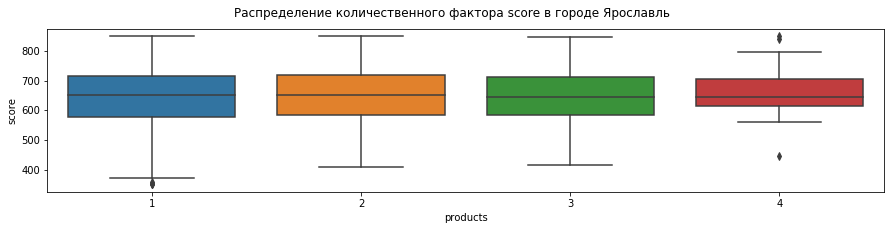

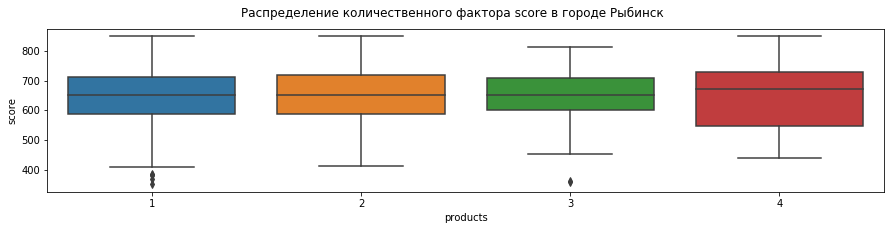

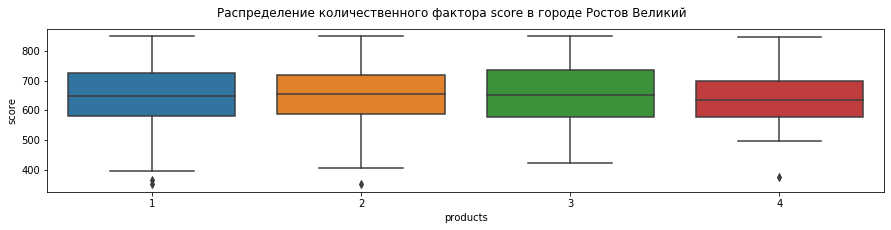

In [21]:
city_factor(data_Yaroslavl, 'score', 'Ярославль')
city_factor(data_Fishinsk, 'score', 'Рыбинск')
city_factor(data_Rostov_the_Great, 'score', 'Ростов Великий')

#### Вывод:
С точки зрения кредитного скоринга показатели во всех городах примерно похожи:
- Можно выделить, что в 4-й группе в городе Рыбинске разброс в показателе чуть выше, чем в других городах; при этом среднее значение показателя выше.
- Для групп 1 и 2 во всех городах показатели примерно одного порядка;
- Для группы №3 в городе Ростов Великий разброс в показателе выше, чем в других городах, при этом средний показатель тот же.

### Смотрим на возраст

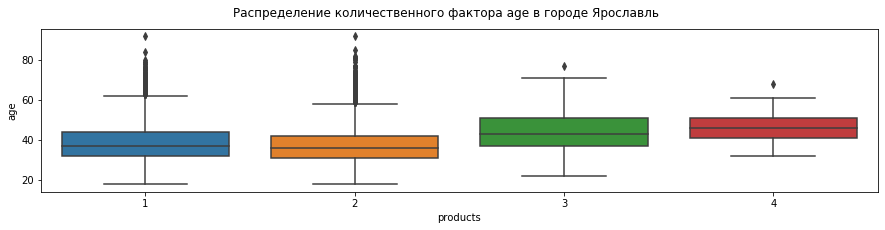

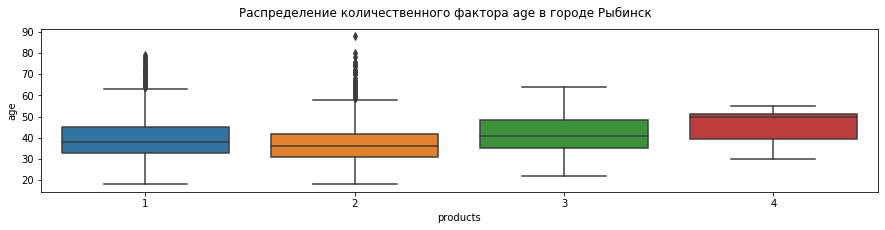

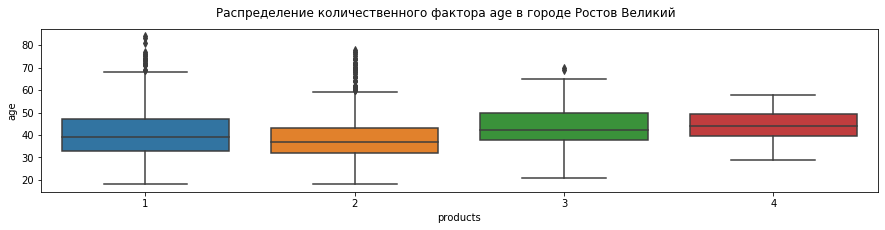

In [22]:
city_factor(data_Yaroslavl, 'age', 'Ярославль') 
city_factor(data_Fishinsk, 'age', 'Рыбинск') 
city_factor(data_Rostov_the_Great, 'age', 'Ростов Великий') 

#### Вывод:
Видим сильное изменение возрастных показателей в зависимости от типа продукта:
- Во всех городах в группах 1 и 2 люди в среднем моложе, чем в группах 3 и 4;
- Также можно заметить, что в группе с 2-я продуктами люди чуть моложе, чем в группе с 1;
- В группе с одним продуктом в Ростове Великом разброс выше, чем в других городах, люди там в среднем чуть старше;
- Самая старая группа - пользователи с 4-я продуктами в городе Рыбинск, все пользователи с 4-я продуктами в среднем старше.

### Смотрим на количество объектов в собственности

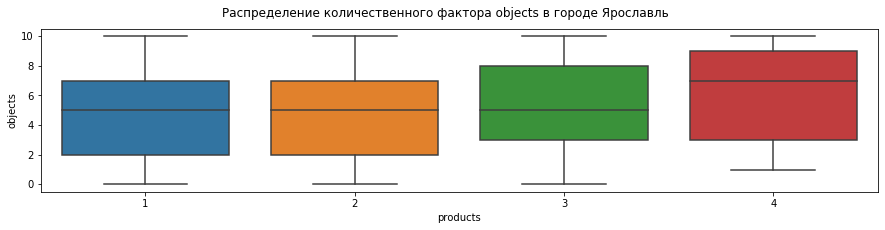

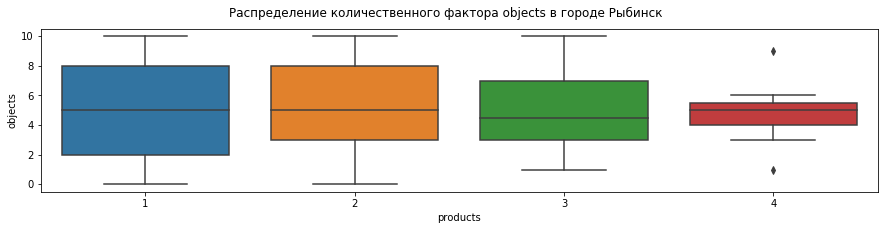

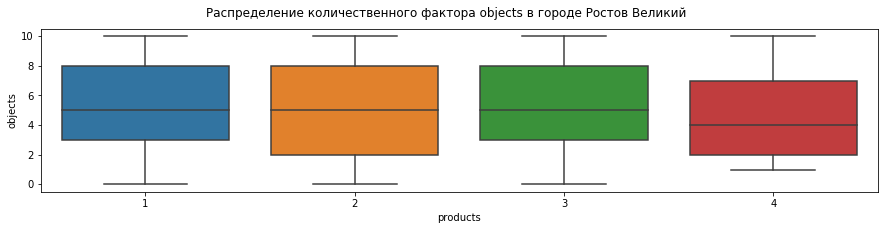

In [23]:
city_factor(data_Yaroslavl, 'objects', 'Ярославль') 
city_factor(data_Fishinsk, 'objects', 'Рыбинск') 
city_factor(data_Rostov_the_Great, 'objects', 'Ростов Великий') 

#### Вывод:
- Количество объектов даёт очень интересную картину в зависимости от города и количества продукта:
-- В Ярославле у людей из групп 1 и 2 в среднем от 2 до 7 объектов, когда как в группах 3 и 4 этот показатель составляет от 3 до 8-9. При этом средний показатель 5 характерен для групп 1, 2 и 3, в 4-й группе он заметно выше - 7.
-- В Рыбинске средний показатель 5 характерен только для пользователей из 1-й и 2-й группы, в 3-й он чуть ниже, а в 4-й чуть выше. При этом изменилось соотношение между группами 1 и 2 - в первой количество от 2 до 8, во второй от 3 до 8; получается, что в Рыбинске, по сравнению с Ярославлем, у первой и второй группы максимальное количество объектов в собственности чуть выше.
В 3-й группе в Рыбинске максимальное количество объектов, наоборот, меньше, чем в той же группе в Ярославле. В 4-й группе сильно изменился разброс в значениях, вероятно это связано с малым количеством данных.
-- В Ростове Великом, также как в Яролавле, средний показатель 5 характерен для групп 1, 2 и 3, а в 4-й группе он, наоборот, ниже - 4. При этом опять изменилось соотношение между группами 1 и 2 - в первой количество от 3 до 8, во второй от 2 до 8; получается, что в Ростове Великом, по сравнению с Рыбинском и Ярославлем, у первой группы максимальное количество объектов в собственности чуть выше.

### Смотрим на баланс средств на счёте

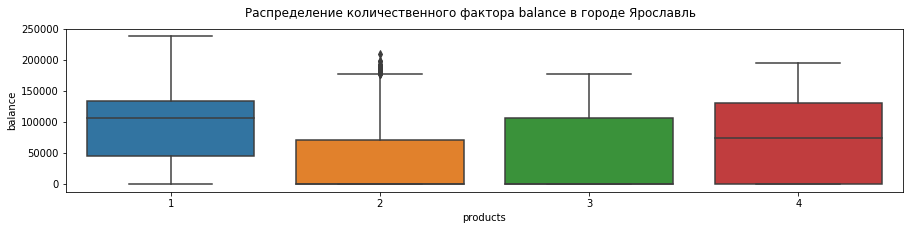

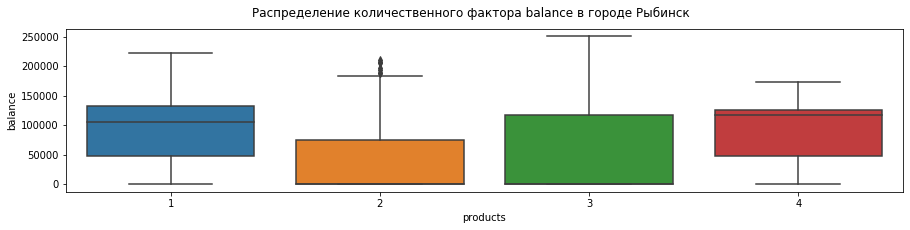

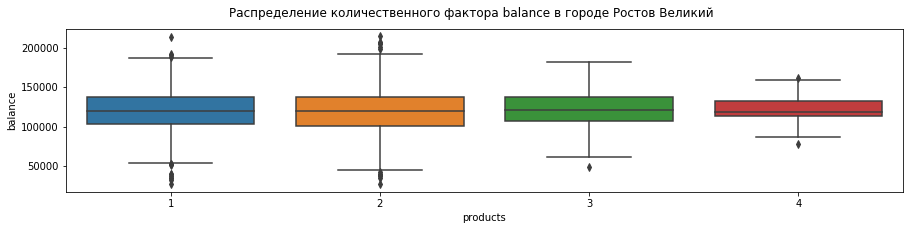

In [24]:
city_factor(data_Yaroslavl, 'balance', 'Ярославль') 
city_factor(data_Fishinsk, 'balance', 'Рыбинск') 
city_factor(data_Rostov_the_Great, 'balance', 'Ростов Великий')

#### Вывод:
- Общая сумма денег тоже различается у групп в зависимости от города и количества продукта:
-- Для людей с одним продуктом:
-- - В Ярославле и Рыбинске средний показатель держится в районе 100000 рублей; 
-- - В Ростове Великом он заметно выше - 125000 рублей, а разброс меньше. 
-- Для людей с двумя продуктами:
-- - В Ярославле и Рыбинске на балансе чаще можно встретить 0, поэтому средний показатель смещён в сторону 50000 рублей.
-- - В Ростове Великом он заметно выше - 125000 рублей, потому что 0 меньше.
-- Для людей с тремя продуктами характерно то же распределение, что и для людей с двумя, только в Ярославле и Рыбинске средний показатель выше - 100000
-- Для людей с четырьмя продуктами характерно высокое среднее значение для всех городов - 100000 - 125000 рублей, разброс сильно разнится от города к городу.

### Смотрим на предполагаемую заработную плату клиента

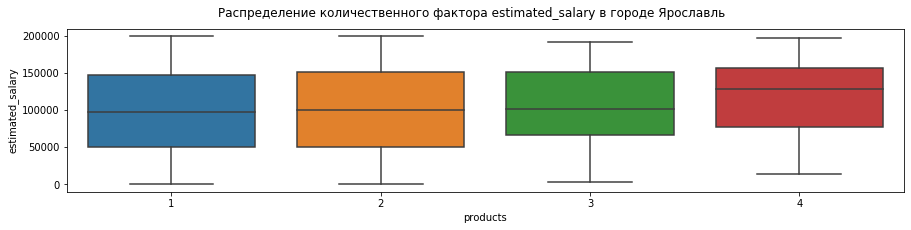

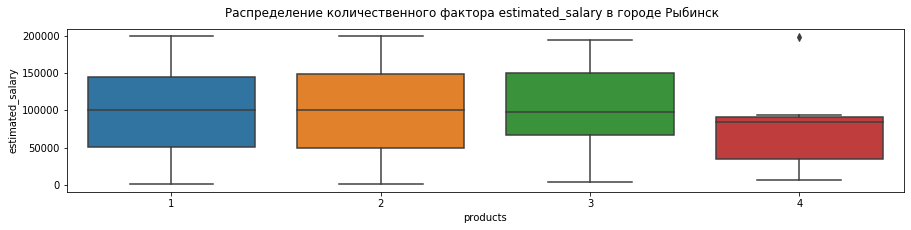

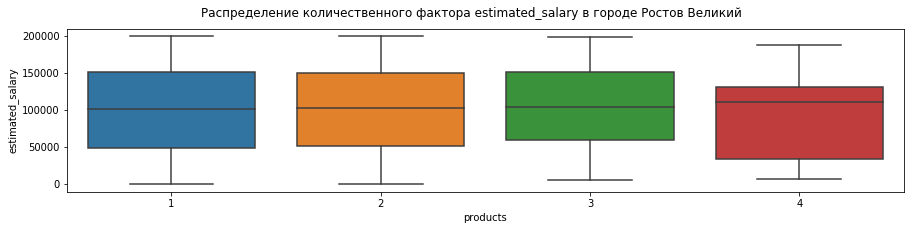

In [25]:
city_factor(data_Yaroslavl, 'estimated_salary', 'Ярославль') 
city_factor(data_Fishinsk, 'estimated_salary', 'Рыбинск') 
city_factor(data_Rostov_the_Great, 'estimated_salary', 'Ростов Великий')

#### Вывод:
- Определяемая зарплата по группам во всех городах примерно одинаковая, выделяется только 4-я:
-- В Рыбинске она меньше, чем в Ярославле и Ростове Великом.

### Общий вывод:
Довольно интересные результаты! Мы видим, что пользователи немного отличаются от города к городу:

С точки зрения кредитного скоринга показатели во всех городах примерно похожи:
- Можно выделить, что в 4-й группе в городе Рыбинске разброс в показателе чуть выше, чем в других городах; при этом среднее значение показателя выше.
- Для групп 1 и 2 во всех городах показатели примерно одного порядка;
- Для группы №3 в городе Ростов Великий разброс в показателе выше, чем в других городах, при этом средний показатель тот же.

Видим сильное изменение возрастных показателей в зависимости от типа продукта:
- Во всех городах в группах 1 и 2 люди в среднем моложе, чем в группах 3 и 4;
- Также можно заметить, что в группе с 2-я продуктами люди чуть моложе, чем в группе с 1;
- В группе с одним продуктом в Ростове Великом разброс выше, чем в других городах, люди там в среднем чуть старше;
- Самая старая группа - пользователи с 4-я продуктами в городе Рыбинск, все пользователи с 4-я продуктами в среднем старше.

Количество объектов даёт очень интересную картину в зависимости от города и количества продукта:
- В Ярославле у людей из групп 1 и 2 в среднем от 2 до 7 объектов, когда как в группах 3 и 4 этот показатель составляет от 3 до 8-9. При этом средний показатель 5 характерен для групп 1, 2 и 3, в 4-й группе он заметно выше - 7.
- В Рыбинске средний показатель 5 характерен только для пользователей из 1-й и 2-й группы, в 3-й он чуть ниже, а в 4-й чуть выше. При этом изменилось соотношение между группами 1 и 2 - в первой количество от 2 до 8, во второй от 3 до 8; получается, что в Рыбинске, по сравнению с Ярославлем, у первой и второй группы максимальное количество объектов в собственности чуть выше.
- В 3-й группе в Рыбинске максимальное количество объектов, наоборот, меньше, чем в той же группе в Ярославле. В 4-й группе сильно изменился разброс в значениях, вероятно это связано с малым количеством данных.
- В Ростове Великом, также как в Яролавле, средний показатель 5 характерен для групп 1, 2 и 3, а в 4-й группе он, наоборот, ниже - 4. При этом опять изменилось соотношение между группами 1 и 2 - в первой количество от 3 до 8, во второй от 2 до 8; получается, что в Ростове Великом, по сравнению с Рыбинском и Ярославлем, у первой группы максимальное количество объектов в собственности чуть выше.

Общая сумма денег тоже различается у групп в зависимости от города и количества продукта:
- Для людей с одним продуктом:
-- В Ярославле и Рыбинске средний показатель держится в районе 100000 рублей; 
--  В Ростове Великом он заметно выше - 125000 рублей, а разброс меньше. 
- Для людей с двумя продуктами:
--  В Ярославле и Рыбинске на балансе чаще можно встретить 0, поэтому средний показатель смещён в сторону 50000 рублей.
--  В Ростове Великом он заметно выше - 125000 рублей, потому что 0 меньше.
- Для людей с тремя продуктами характерно то же распределение, что и для людей с двумя, только в Ярославле и Рыбинске средний показатель выше - 100000
- Для людей с четырьмя продуктами характерно высокое среднее значение для всех городов - 100000 - 125000 рублей, разброс сильно разнится от города к городу.

Определяемая зарплата по группам во всех городах примерно одинаковая, выделяется только 4-я:
- В Рыбинске она меньше, чем в Ярославле и Ростове Великом.

Если сегментировать пользователей по количеству продуктов и городу, то можно выделить 8 групп:
- пользователи с 1-м продуктом в городах Ярославль и Рыбинск;
- пользователи с 1-м продуктом в городе Ростов Великий;
- пользователи с 2-я продуктами в городах Ярославль и Рыбинск;
- пользователи с 2-я продуктами в городе Ростов Великий;
- пользователи с 3-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;
- пользователи с 4-я продуктами в городе Ярославль и Рыбинск;
- пользователи с 4-я продуктами в городе Рыбинск;
- пользователи с 4-я продуктами в городе Ростов Великий;

С другой стороны, нужно понимать, что количество пользователей с 3-я и 4-я продуктами очень мало, поэтому нет особого смысла в том, чтобы делить их так дробно. Предлагаю упростить картину до 6-и групп:
- пользователи с 1-м продуктом в городах Ярославль и Рыбинск;
- пользователи с 1-м продуктом в городе Ростов Великий;
- пользователи с 2-я продуктами в городах Ярославль и Рыбинск;
- пользователи с 2-я продуктами в городе Ростов Великий;
- пользователи с 3-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;
- пользователи с 4-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;

В следующем пункте посмотрим, как пол влияет на показатели, возъмём две самые крупные группы с 1-м и 2-я продуктами.

## Давайте теперь добавим в нашу картину разделение по гендерному признаку

In [26]:
data_Yaroslavl_men = data[(data['city'] == 0) & (data['gender'] == 1) & ((data['products'] == 1) | (data['products'] == 2))]
data_Yaroslavl_women = data[(data['city'] == 0) & (data['gender'] == 0) & ((data['products'] == 1) | (data['products'] == 2))]
data_Fishinsk_men = data[(data['city'] == 1) & (data['gender'] == 1) & ((data['products'] == 1) | (data['products'] == 2))]
data_Fishinsk_women = data[(data['city'] == 1) & (data['gender'] == 0) & ((data['products'] == 1) | (data['products'] == 2))]
data_Rostov_the_Great_men = data[(data['city'] == 2) & (data['gender'] == 1) & ((data['products'] == 1) | (data['products'] == 2))]
data_Rostov_the_Great_women = data[(data['city'] == 2) & (data['gender'] == 0) & ((data['products'] == 1) | (data['products'] == 2))]

### Смотрим на баллы кредитного скоринга

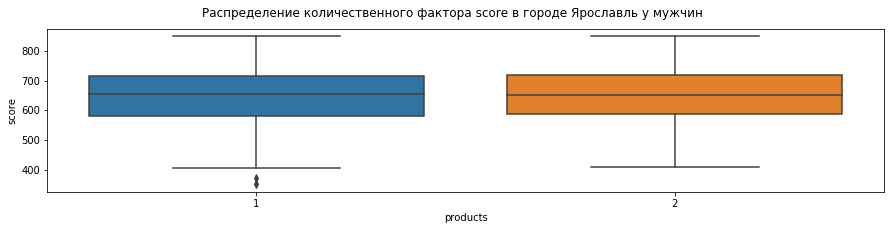

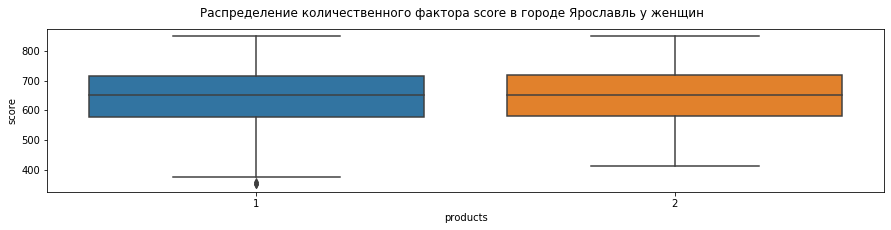

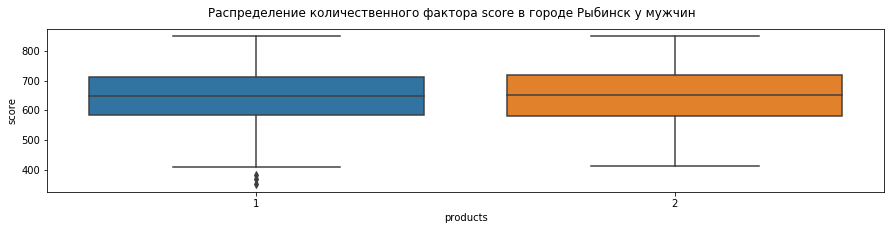

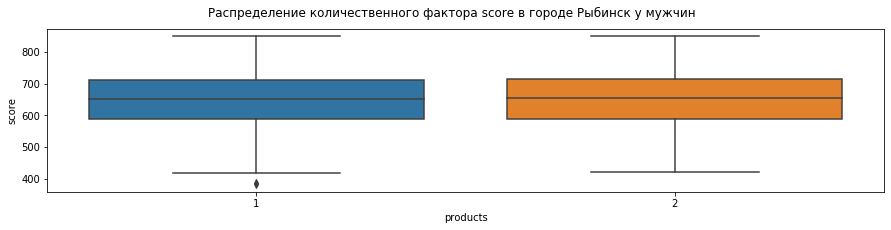

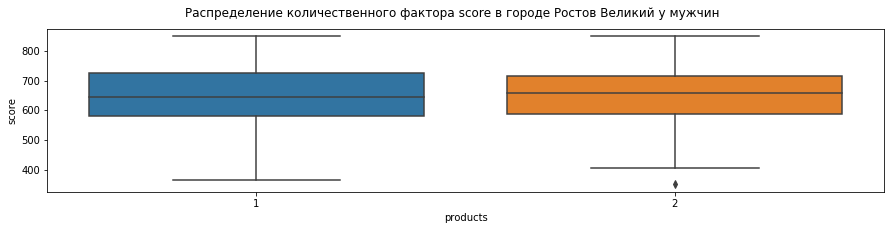

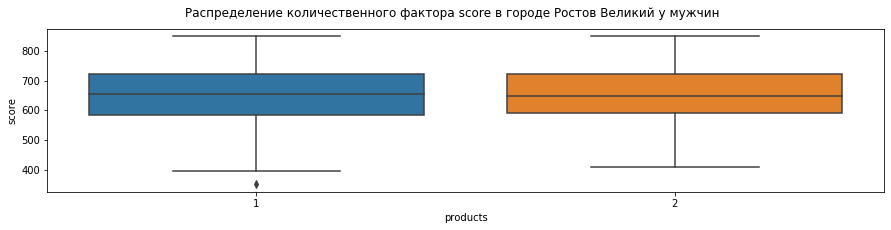

In [27]:
def city_factor(city, factor, city_name):
    plt.figure(figsize=(15, 3))
    sns.boxplot(data=city, x='products', y=factor)
    plt.suptitle('Распределение количественного фактора ' + factor + ' в городе ' + city_name)
    plt.show()
    
city_factor(data_Yaroslavl_men, 'score', 'Ярославль у мужчин')
city_factor(data_Yaroslavl_women, 'score', 'Ярославль у женщин')
city_factor(data_Fishinsk_men, 'score', 'Рыбинск у мужчин')
city_factor(data_Fishinsk_women, 'score', 'Рыбинск у мужчин')
city_factor(data_Rostov_the_Great_men, 'score', 'Ростов Великий у мужчин')
city_factor(data_Rostov_the_Great_women, 'score', 'Ростов Великий у мужчин')

#### Вывод:
- Средние показатели кредитного скоринга примерно одинаковые.

### Смотрим на возраст

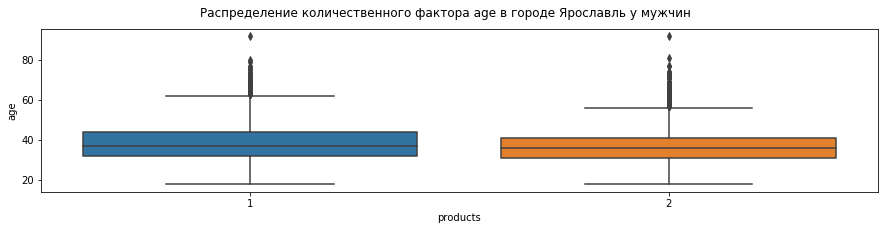

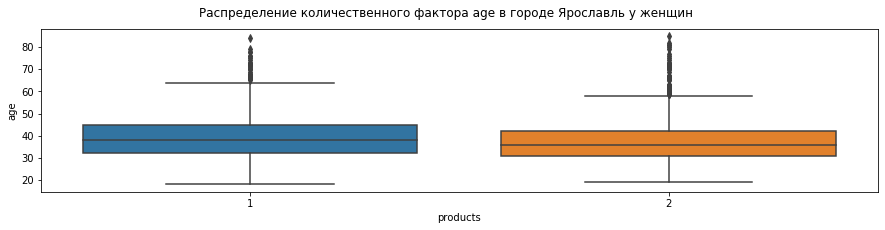

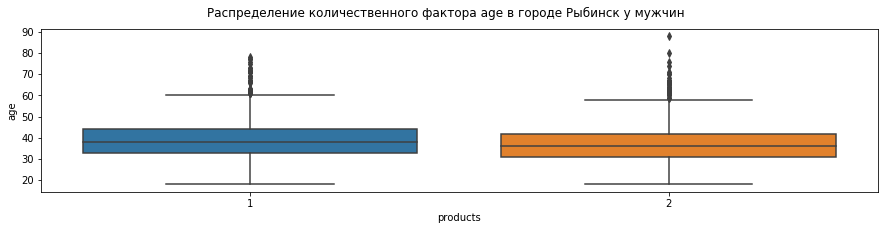

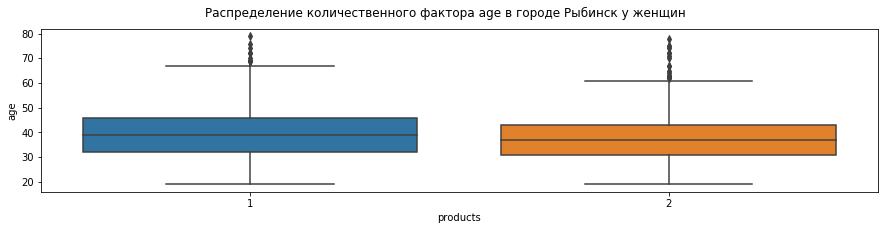

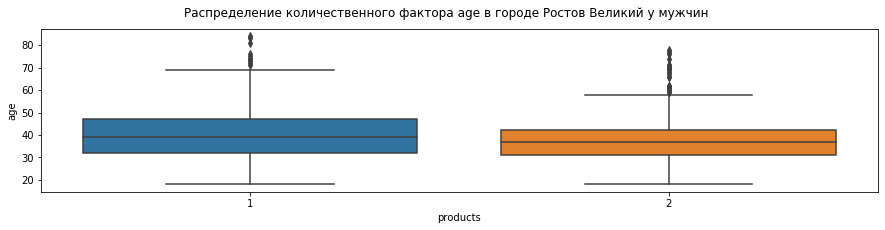

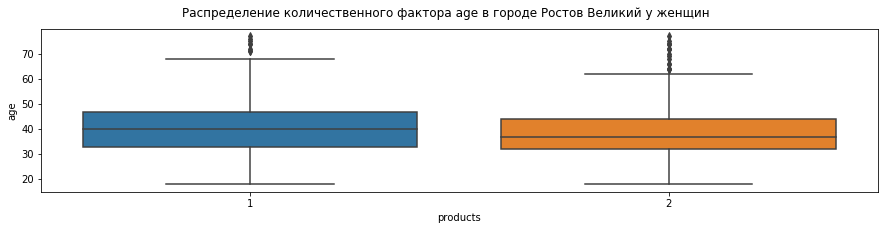

In [28]:
city_factor(data_Yaroslavl_men, 'age', 'Ярославль у мужчин')
city_factor(data_Yaroslavl_women, 'age', 'Ярославль у женщин')
city_factor(data_Fishinsk_men, 'age', 'Рыбинск у мужчин')
city_factor(data_Fishinsk_women, 'age', 'Рыбинск у женщин')
city_factor(data_Rostov_the_Great_men, 'age', 'Ростов Великий у мужчин')
city_factor(data_Rostov_the_Great_women, 'age', 'Ростов Великий у женщин')

#### Вывод:
- Во всех городах люди с двумя продуктами чуть моложе, чем люди с одним продуктом что среди мужчин, что среди женщин;
- В Городе Рыбинск женщины в среднем чуть старше, чем мужчины, это видно на разбросе значений. 

### Смотрим на количество объектов в собственности

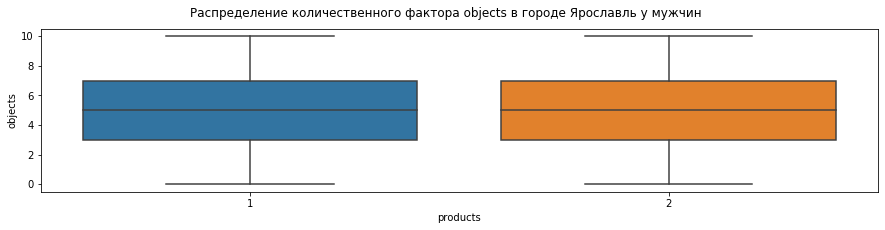

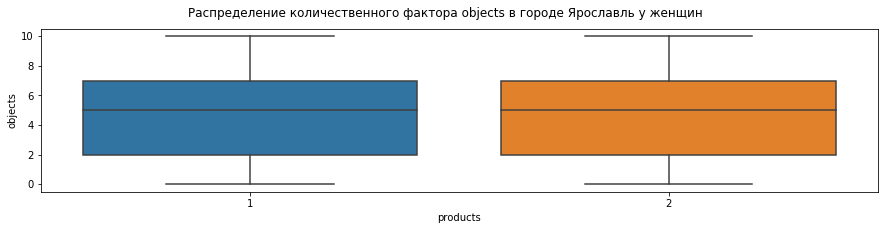

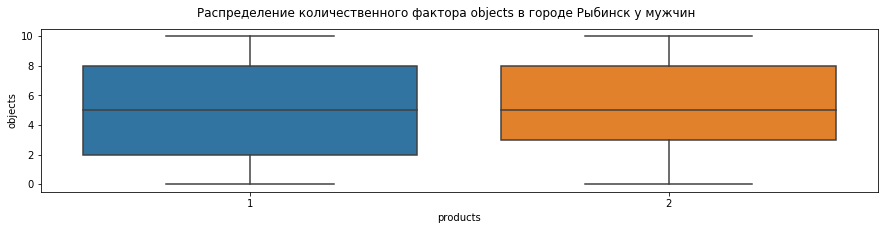

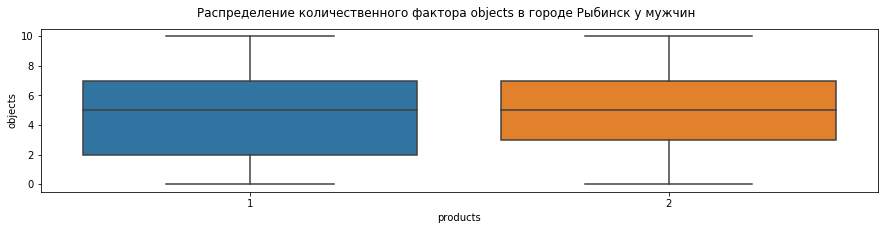

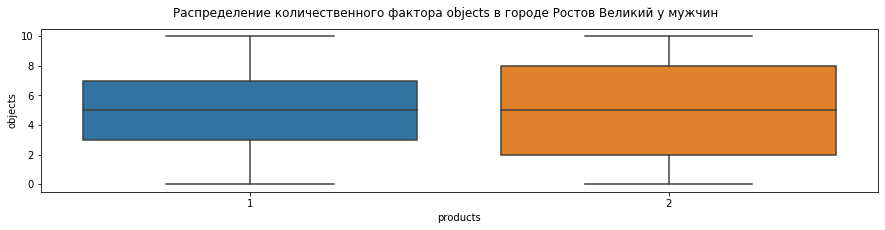

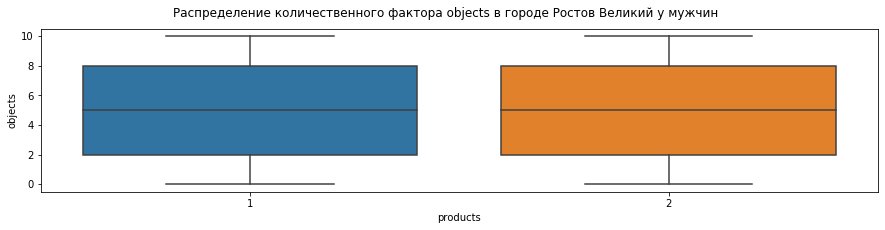

In [29]:
city_factor(data_Yaroslavl_men, 'objects', 'Ярославль у мужчин')
city_factor(data_Yaroslavl_women, 'objects', 'Ярославль у женщин')
city_factor(data_Fishinsk_men, 'objects', 'Рыбинск у мужчин')
city_factor(data_Fishinsk_women, 'objects', 'Рыбинск у мужчин')
city_factor(data_Rostov_the_Great_men, 'objects', 'Ростов Великий у мужчин')
city_factor(data_Rostov_the_Great_women, 'objects', 'Ростов Великий у мужчин')

#### Вывод:
- В городе Ярославль у мужчин минимальное количество объектов на один больше, чем у женщин;
- В городе Рыбинск у женщин с 1-м и 2-я продуктами среднее максимальное количество объектов на один больше, чем у мужчин;
- В городе Ростов Великий у мужчин с одним продуктом среднее количество объектов в собственности от 3 до 7, тогда как у женщин их в среднем от 2 до 8.

### Смотрим на баланс средств счёте

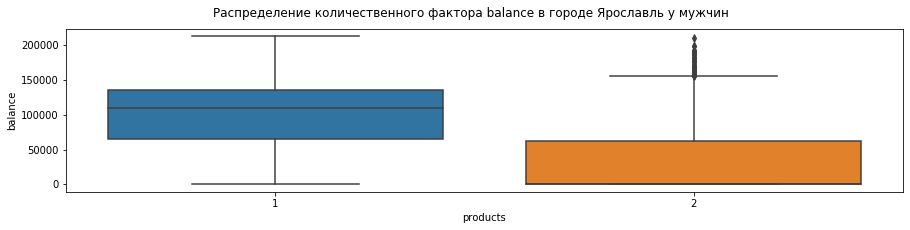

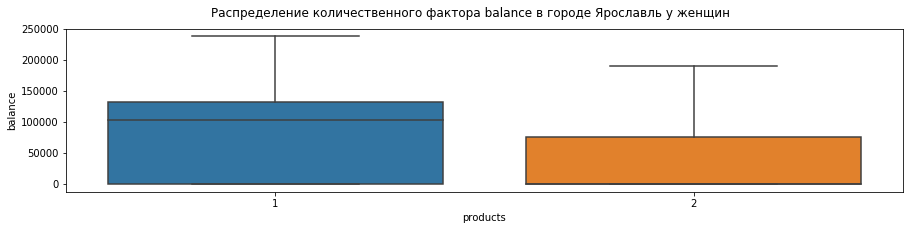

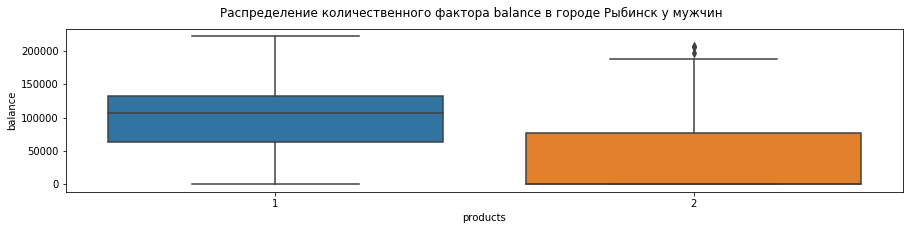

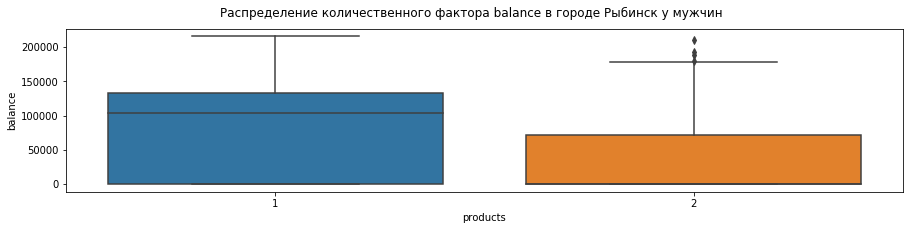

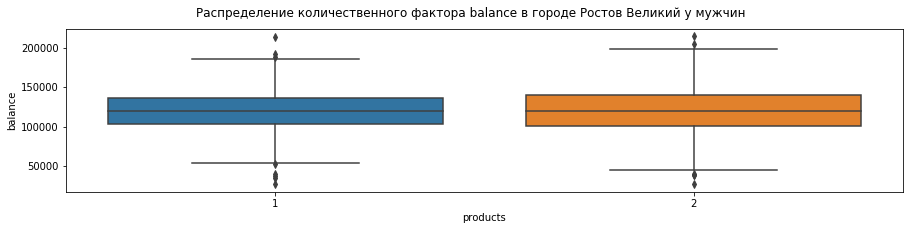

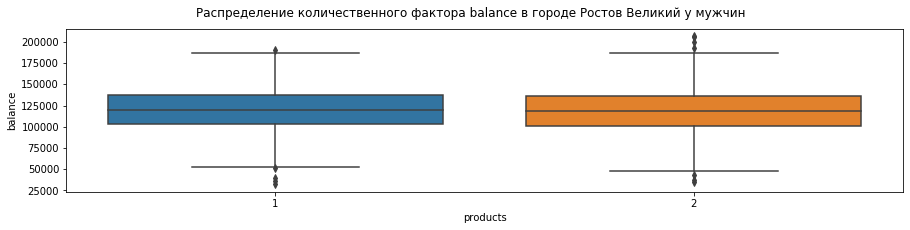

In [30]:
city_factor(data_Yaroslavl_men, 'balance', 'Ярославль у мужчин')
city_factor(data_Yaroslavl_women, 'balance', 'Ярославль у женщин')
city_factor(data_Fishinsk_men, 'balance', 'Рыбинск у мужчин')
city_factor(data_Fishinsk_women, 'balance', 'Рыбинск у мужчин')
city_factor(data_Rostov_the_Great_men, 'balance', 'Ростов Великий у мужчин')
city_factor(data_Rostov_the_Great_women, 'balance', 'Ростов Великий у мужчин')

#### Вывод:
- У обоих полов в городах Ярославль и Рыбинск среднее количество средств выше, если у пользователя один продукт, а не два;
- У женщин в городах Ярославль и Рыбинск чаще на счёте можно встретить 0 на счёте, чем у мужчин;
- В городе Ростов Великий и у мужчин, и у женщин самые высокие показатели - около 125000 рублей на счёте.

### Смотрим на предполагаемую заработную плату клиента

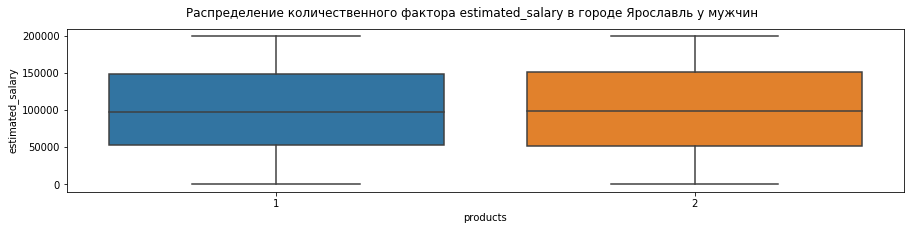

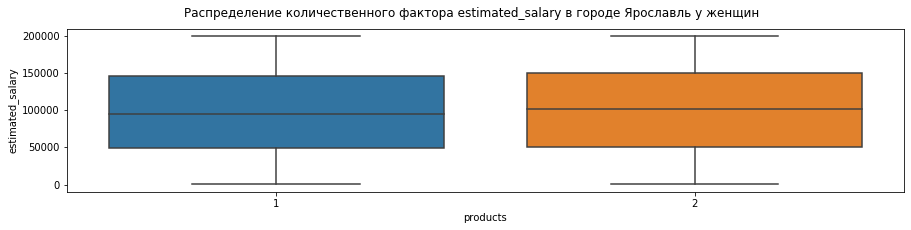

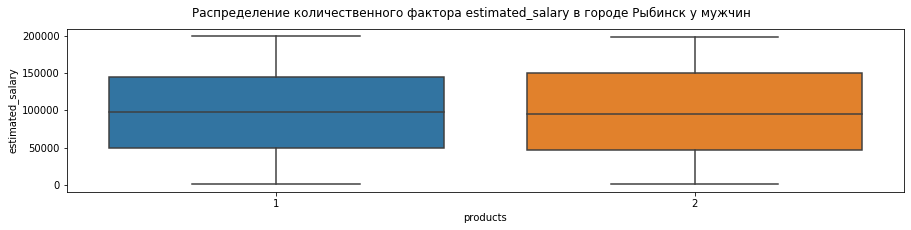

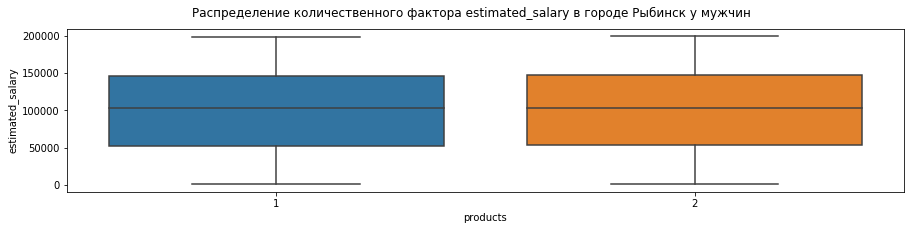

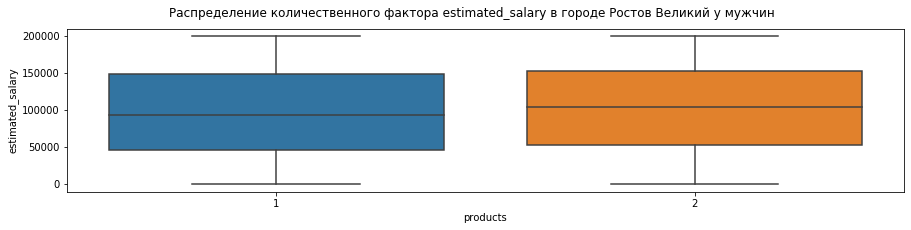

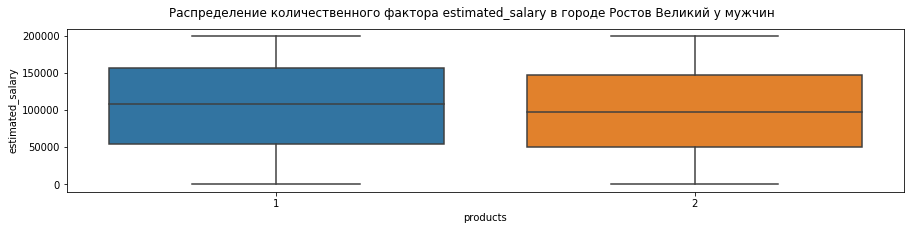

In [31]:
city_factor(data_Yaroslavl_men, 'estimated_salary', 'Ярославль у мужчин')
city_factor(data_Yaroslavl_women, 'estimated_salary', 'Ярославль у женщин')
city_factor(data_Fishinsk_men, 'estimated_salary', 'Рыбинск у мужчин')
city_factor(data_Fishinsk_women, 'estimated_salary', 'Рыбинск у мужчин')
city_factor(data_Rostov_the_Great_men, 'estimated_salary', 'Ростов Великий у мужчин')
city_factor(data_Rostov_the_Great_women, 'estimated_salary', 'Ростов Великий у мужчин')

#### Вывод:
- Предполагаемая заработная плата у обоих полов примерно одинаковая вне зависимости от количества продуктов.

### Общие выводы:
Показатели по всем параметрам очень похожи друг на друга у мужчин и женщин, почти полная гендерная справедливость;
- Средние показатели кредитного скорринга примерно одинаковые;

- Во всех городах люди с двумя продуктами чуть моложе, чем люди с одним продуктом что среди мужчин, что среди женщин;
- В городе Рыбинск женщины в среднем чуть старше, чем мужчины, это видно на разбросе значений; 

- В городе Ярославль у мужчин минимальное количество объектов на один больше, чем у женщин;
- В городе Рыбинск у женщин с 1-м и 2-я продуктами среднее максимальное количество объектов на один больше, чем у мужчин;
- В городе Ростов Великий у мужчин с одним продуктом среднее количество объектов в собственности от 3 до 7, тогда как у женщин их в среднем от 2 до 8.

- У обоих полов в городах Ярославль и Рыбинск среднее количество средств выше, если у пользователя один продукт, а не два;
- У женщин в городах Ярославль и Рыбинск чаще на счёте можно встретить 0 на счёте, чем у мужчин;
- В городе Ростов Великий и у мужчин, и у женщин самые высокие показатели - около 125000 рублей на счёте.

- Предполагаемая заработная плата у обоих полов примерно одинаковая вне зависимости от количества продуктов, это характерно для всех городов.

Выводы, полученные при таком подходе, подтверждаю тезис, что города Ярославль и Рыбинск стоит отнести в одну группу, а город Ростов Великий в другую. Конечно, можно выделить особые черты в каждом городе в зависимости от пола, но я не считаю отличия достаточно значимыми, чтобы на их основе выделять новые группы. Поэтому давайте остановимся на таком разделении:
- пользователи с 1-м продуктом в городах Ярославль и Рыбинск;
- пользователи с 1-м продуктом в городе Ростов Великий;
- пользователи с 2-я продуктами в городах Ярославль и Рыбинск;
- пользователи с 2-я продуктами в городе Ростов Великий;
- пользователи с 3-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;
- пользователи с 4-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;

<div class='alert alert-success'>
У тебя весьма ловко получилось автоматизировать построение графиков. Причем большинство из них получились со всеми подписями осей и группировкой на одном полотне – это весьма похвально, говорит о твоих хороших алгоритмических навыках.

## Матрица корреляций

In [32]:
data_corr = data.copy(deep=True)
del data_corr['city']
del data_corr['gender']
data_corr

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
0,15677338,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,39,5,0.00,2,1,0,96270.64,0,0,0,1,0,1
9996,15612628,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,15627268,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,1,0
9998,15725091,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


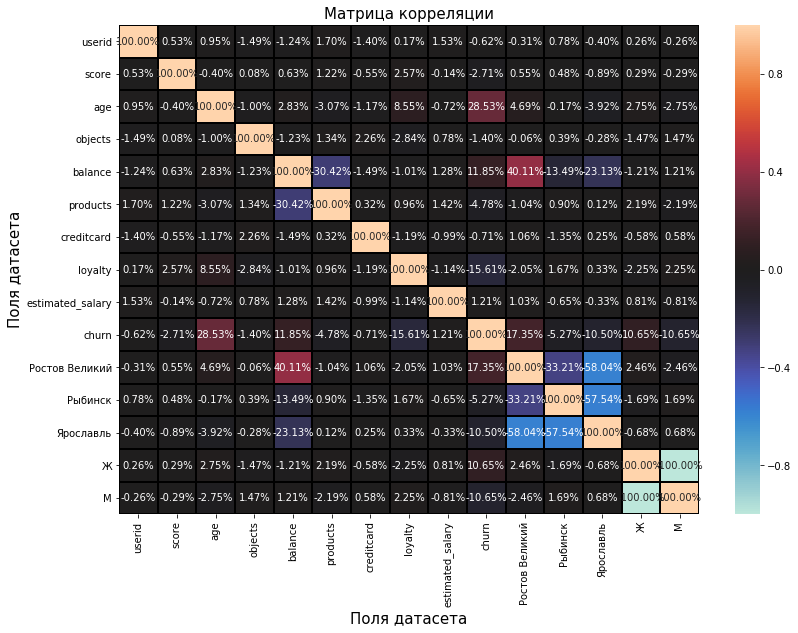

In [33]:
# Создадим тепловую карту
cm = data_corr.corr()  
plt.figure(figsize=(13, 9))
plt.title('Матрица корреляции', fontsize = 15)
sns.heatmap(cm, annot=True, fmt='.2%', linewidths=1, linecolor='black', 
             xticklabels= cm.columns, yticklabels= cm.index,
             vmin=-1, vmax=1, center= 0)
plt.xlabel('Поля датасета', fontsize = 15);
plt.ylabel('Поля датасета', fontsize = 15);
plt.show()

#### Выводы:
В данных есть пары признаков, которые можно назвать почти мультиколлинеарными:
- balance и products;
- balance и Ростов Великий;
- balance и Ярославль;
- churn и age;

Для нас важным фактором будет взаимосвязь количества продуктов и баланса средств на карте.

<div class='alert alert-warning'>
Я рад что ты владеешь такой мощной техникой визуализации. По тепловой карте действительно видно что особых зависимостей между признаками не наблюдается. В  таком случае я рекомендую делать дополнительные расчеты корреляции Спирмена или Phik, чтобы исключить ситуацию когда мы не уловили нелинейные зависимости.
Также тебе нужно быть внимательным с выбором кодирования признаков. Если ты изменишь величины в признаке городов, то ты получишь совсем другую картину. Для верного расчета корреляций тебе нужно использовать one-hot кодировку.

<div class="alert alert-block alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Сделал с помощью One-Hot Encoding :) </div>

## Кластеризация клиентов

In [34]:
# Так как основные пользователи у нас пользуются либо одним продуктом, либо двумя, то я предлагаю взять их для кластеризации
data_1_2 = data_corr.loc[data_corr[(data_corr['products'] == 1) | (data_corr['products'] == 2)].index]
data_1_2 

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,Ростов Великий,Рыбинск,Ярославль,Ж,М
0,15677338,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
3,15744090,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0
5,15616748,645,44,8,113755.78,2,1,0,149756.71,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,39,5,0.00,2,1,0,96270.64,0,0,0,1,0,1
9996,15612628,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9997,15627268,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,1,0
9998,15725091,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


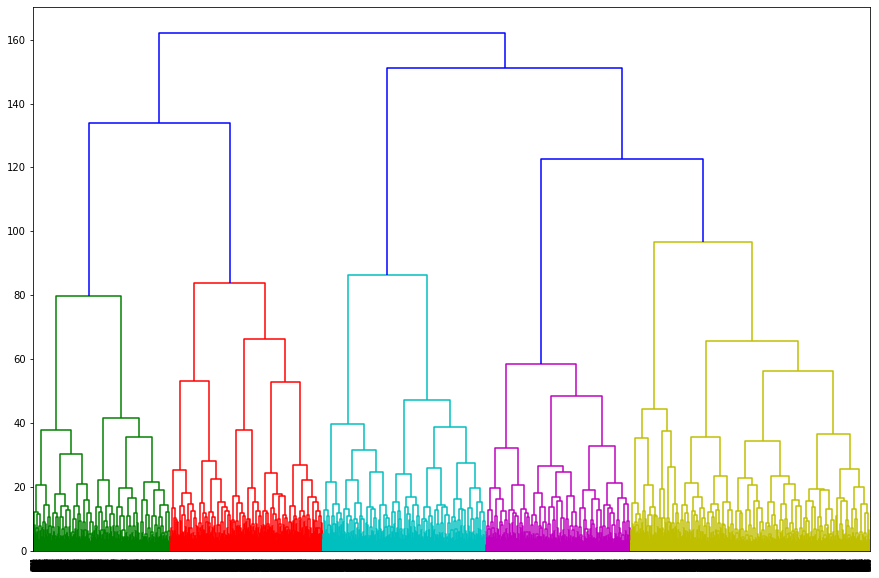

In [35]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data_1_2.drop(columns=['products'])
y = data_1_2['products']

# Стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [36]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле датасета
data_1_2['cluster'] = labels

In [37]:
# выводим статистику по средним значениям признаков по кластеру
data_1_2.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
userid,1.573522e+07,1.573461e+07,1.573172e+07,1.573500e+07,1.573073e+07
score,6.491326e+02,6.514725e+02,6.501622e+02,6.495922e+02,6.535631e+02
age,3.854641e+01,3.881739e+01,3.817335e+01,3.922724e+01,3.995204e+01
objects,4.935985e+00,5.039101e+00,5.045286e+00,5.030087e+00,4.995560e+00
balance,6.032280e+04,6.210076e+04,6.389366e+04,1.200956e+05,1.191266e+05
products,1.489712e+00,1.492097e+00,1.481069e+00,1.457641e+00,1.410302e+00
creditcard,6.982167e-01,6.967554e-01,7.130661e-01,7.181314e-01,7.051510e-01
loyalty,5.171468e-01,5.332779e-01,5.193022e-01,5.273159e-01,4.715808e-01
estimated_salary,9.953978e+04,9.940109e+04,9.987406e+04,1.000845e+05,1.019066e+05
churn,1.796982e-01,1.472546e-01,1.135857e-01,2.501979e-01,3.445826e-01


In [38]:
data_1_2.groupby(['cluster']).std().T

cluster,0,1,2,3,4
userid,70435.730257,71819.008083,72106.667647,71895.352152,74208.556618
score,97.880810,94.274105,96.602800,97.834829,98.304041
age,10.617918,10.452055,10.242946,10.611934,10.425499
objects,2.893429,2.866014,2.875849,2.870261,3.010644
balance,63571.457980,64117.611445,64636.192152,27801.411671,26383.160353
products,0.500008,0.500042,0.499734,0.498400,0.492107
creditcard,0.459137,0.459756,0.452414,0.450088,0.456177
loyalty,0.499820,0.498995,0.499720,0.499451,0.499414
estimated_salary,57413.085294,57171.244056,57443.960590,58256.709644,58269.196671
churn,0.384024,0.354433,0.317366,0.433298,0.475443


### Вывод:
Кластеризация предложила разделение всего датафрейма людей с одним/двумя продуктами на 5 принципиальных групп, важными признаками разделения являются кредитный скоринг, город, баланс на карте, активность и факт оттока.
В целом, те выводы, которые я сделал при ручном разборе параметров, сходятся с тем, что нам предлагает кластеризация. Можно сказать, что внутри двух групп с одним и двумя продуктами достаточно различий, чтобы разделить их на как минимум 3 группы.

<div class='alert alert-success'>
Очень похвально что взялся за машинное обучение в данном проекте, это отличная возможность попрактиковать свои навыки моделирования. 

##  Проверка гипотез

### Гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

In [39]:
# разделим датасет на 2 части - пользователи с одним продуктом и пользователи с двумя продуктами
data_one_product = data.loc[data[(data['products'] == 1)].index]
data_two_products = data.loc[data[(data['products'] == 2)].index]

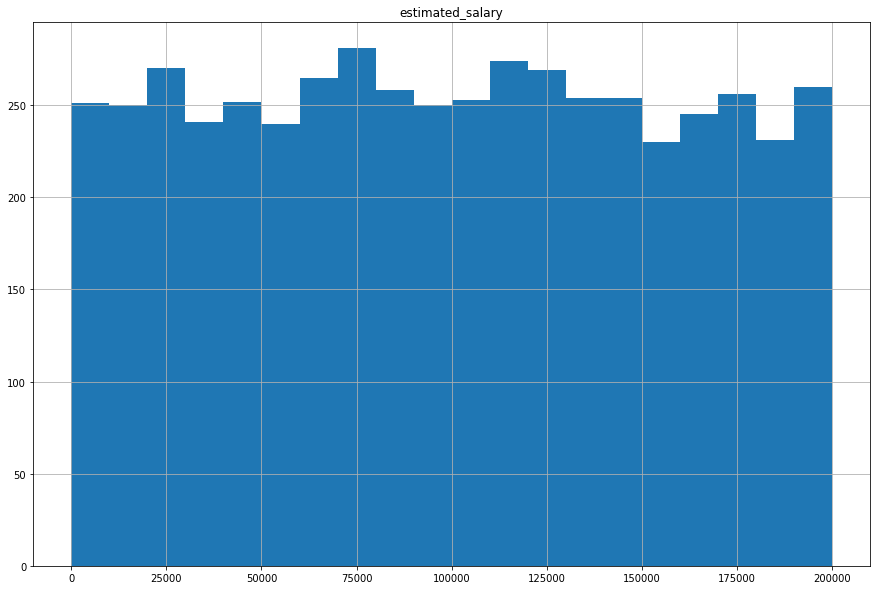

In [40]:
features = list(set(['estimated_salary']))

data_one_product[features].hist(figsize=(15,10), bins = 20);

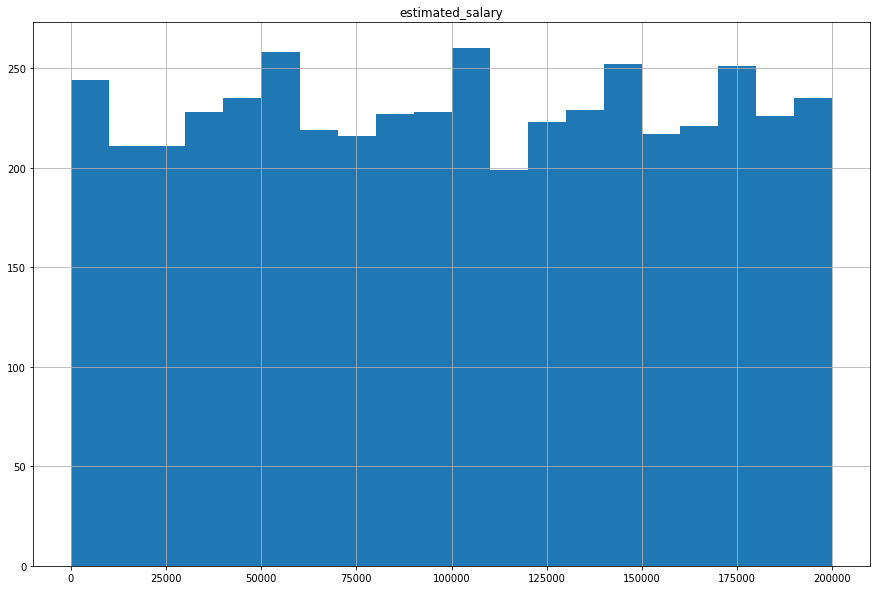

In [41]:
data_two_products[features].hist(figsize=(15,10), bins = 20);

In [42]:
data_one_product['estimated_salary'].mean()

99487.25685090481

In [43]:
data_two_products['estimated_salary'].mean()

100452.01282135077

Видим, что данные распределены равномерно, а средние значения примерно равны, разница составляет всего тысячу рублей (около 1 %); данные не придётся избавлять от выбросов при проверке гипотез. 

- Нулевая гипотеза H0 - средний доход пользователей с одним и двумя продуктами равны;
- Альтернативная гипотеза H1 - средий доход пользователей с одним и двумя продуктами не равна.
Гипотезы получились двусторонними.
Для проверки гипотез будем использовать тест Манна-Уитни, p-value возьмём на уровне минимальной статистической значимости, равной 0,05.

In [44]:
stat, p = mannwhitneyu(data_one_product['estimated_salary'], data_two_products['estimated_salary'])
print('Statistics=%.3f, p = %.3f' % (stat, p))
alpha = .05
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Statistics=11554276.000, p = 0.204
Не получилось отвергнуть нулевую гипотезу


#### Вывод:
Cредний доход пользователей с одним и двумя продуктами равны.

### Гипотеза различия дохода между клиентами разного пола, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

In [45]:
data_one_product_man = data.loc[data[(data['products'] == 1) & (data['gender'] == 1)].index]
data_one_product_women = data.loc[data[(data['products'] == 1) & (data['gender'] == 0)].index]
data_two_products_man = data.loc[data[(data['products'] == 2) & (data['gender'] == 1)].index]
data_two_products_women = data.loc[data[(data['products'] == 2) & (data['gender'] == 0)].index]

In [46]:
data_one_product_man['estimated_salary'].mean()

98675.00478837878

In [47]:
data_one_product_women['estimated_salary'].mean()

100473.56292682927

In [48]:
data_two_products_man['estimated_salary'].mean()

100534.35843478263

In [49]:
data_two_products_women['estimated_salary'].mean()

100350.87961650486

А вот это уже интересно. Видно, что у мужчин, которые пользуются одним продуктом, зарплата на 2 процента ниже, чем у женщин.
- Нулевая гипотеза H0 - средий доход мужчин и женщин с одним продуктом одинаков;
- Альтернативная гипотеза H1 - средий доход мужчин и женщин с одним продуктом различен.

Гипотезы получились двусторонними.

In [50]:
stat, p = mannwhitneyu(data_one_product_man['estimated_salary'], data_one_product_women['estimated_salary'])
print('Statistics=%.3f, p = %.3f' % (stat, p))
alpha = .05
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

Statistics=3142608.000, p = 0.133
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза H0 - средий доход мужчин и женщин с двумя продуктами одинаков.

Альтернативная гипотеза H1 - средий доход мужчин и женщин с двумя продуктами различен.

Гипотезы получились двусторонними. Для проверки гипотез будем использовать тест Манна-Уитни, p-value возьмём на уровне минимальной статистической значимости, равной 0,05.

In [51]:
stat, p = mannwhitneyu(data_two_products_man['estimated_salary'], data_two_products_women['estimated_salary'])
print('Statistics=%.3f, p = %.3f' % (stat, p))
alpha = .05
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")   

Statistics=2601023.000, p = 0.457
Не получилось отвергнуть нулевую гипотезу


#### Вывод:
- Средний доход мужчин и женщин с одним продуктом одинаков;
- Средний доход мужчин и женщин с двумя продуктами одинаков.

<div class='alert alert-danger'>
Проверка стат гипотез проведена не в полной мере верно. Нет проверки предпоссылок для выбора стат критерия. Также для теста Стъюдента нет проверки на равенство дисперсий, это тоже желательно делать с помощью стат теста. Не понятно почему одна гипотеза проверяется с помощью разных стат критериев для которые гипотезы формулируются по разному. Тебе прежде всего нужно оценить распределение данных, далее подобрать стат критерий и правильно сформулировать стат гипотезу отосительно того стат критерия который используется. 


<div class="alert alert-block alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Исправил.</div>

<div class='alert alert-success'>
Принято

## Формулировка выводов и базовые рекомендации по работе с клиентами

### Общие выводы:
1) При просмотре всех показателей по 4-м группам в зависимости от количества продуктов можно выделить следующее:
- Показатели кредитного скоринга во всех 4-х групп примерно одинаковые, хотя в 1-й группе больше выбросов, чем в остальных;
- Возраст сильно отличается во всех группах: в первой и второй он заметно ниже, чем в 3-й и 4-й;
- Если среднее количество объектов у всех групп одинаковое, то разброс значений показывает небольшое расхождение:
-- В 4-й группе у каждого пользователя есть как минимум один объект в пользовании;
-- В 1-й группе диапазон значений в среднем соответствует 2-7 объекта, когда как в других группах 3-7 и 3-8 объекта.
- Предполагаемая зарплата в каждой группе примерно одинаковая;
- А вот баланс на карте показывает самые сильные различия между группами:
-- Всех пользователей можно разделить на 2 подгруппы:
-- - В первой будут группы 1 и 4, для которых характерно наличие в среднем 125000 Р на карте; при этом людей с 0 балансом мало;
-- - Во второй будут группы 2 и 3, в которых у значительного количества пользователей нет денег на балансе.
- Также стоит заметить, что в этих группах разное количество реальных пользователей:
-- Подавляющее их количество находится в группах 1 и 2 (то есть у них либо один продукт, либо два);
-- Пользователей, у которых три/четыре продукта в пользовании, очень мало.
- Не стоит и забывать о том, в городе Ярославль(0) столько же пользователей, сколько в других 2-х городах вместе взятых.
- Мужчин в выборке чуть больше, чем женщин.
- Распределение в столбцах score нормальное, в столбце city нормальное с правым хвостом, в столбце balance нормальное с выбросом в районе 0 (это большое количество людей, у которых нет средств на карте).
- Важно заметить, что среди людей с одним продуктом процент оттока выше, чем у людей с двумя продуктами. 


2) Мы видим, что пользователи немного отличаются от города к городу:

С точки зрения кредитного скоринга показатели во всех городах примерно похожи:
- Можно выделить, что в 4-й группе в городе Рыбинске разброс в показателе чуть выше, чем в других городах; при этом среднее значение показателя выше.
- Для групп 1 и 2 во всех городах показатели примерно одного порядка;
- Для группы №3 в городе Ростов Великий разброс в показателе выше, чем в других городах, при этом средний показатель тот же.

Видим сильное изменение возрастных показателей в зависимости от типа продукта:
- Во всех городах в группах 1 и 2 люди в среднем моложе, чем в группах 3 и 4;
- Также можно заметить, что в группе с 2-я продуктами люди чуть моложе, чем в группе с 1;
- В группе с одним продуктом в Ростове Великом разброс выше, чем в других городах, люди там в среднем чуть старше;
- Самая старая группа - пользователи с 4-я продуктами в городе Рыбинск, все пользователи с 4-я продуктами в среднем старше.

Количество объектов даёт очень интересную картину в зависимости от города и количества продукта:
- В Ярославле у людей из групп 1 и 2 в среднем от 2 до 7 объектов, когда как в группах 3 и 4 этот показатель составляет от 3 до 8-9. При этом средний показатель 5 характерен для групп 1, 2 и 3, в 4-й группе он заметно выше - 7.
- В Рыбинске средний показатель 5 характерен только для пользователей из 1-й и 2-й группы, в 3-й он чуть ниже, а в 4-й чуть выше. При этом изменилось соотношение между группами 1 и 2 - в первой количество от 2 до 8, во второй от 3 до 8; получается, что в Рыбинске, по сравнению с Ярославлем, у первой и второй группы максимальное количество объектов в собственности чуть выше.
- В 3-й группе в Рыбинске максимальное количество объектов, наоборот, меньше, чем в той же группе в Ярославле. В 4-й группе сильно изменился разброс в значениях, вероятно это связано с малым количеством данных.
- В Ростове Великом, также как в Яролавле, средний показатель 5 характерен для групп 1, 2 и 3, а в 4-й группе он, наоборот, ниже - 4. При этом опять изменилось соотношение между группами 1 и 2 - в первой количество от 3 до 8, во второй от 2 до 8; получается, что в Ростове Великом, по сравнению с Рыбинском и Ярославлем, у первой группы максимальное количество объектов в собственности чуть выше.

Общая сумма денег тоже различается у групп в зависимости от города и количества продукта:
- Для людей с одним продуктом:
-- В Ярославле и Рыбинске средний показатель держится в районе 100000 рублей; 
--  В Ростове Великом он заметно выше - 125000 рублей, а разброс меньше. 
- Для людей с двумя продуктами:
--  В Ярославле и Рыбинске на балансе чаще можно встретить 0, поэтому средний показатель смещён в сторону 50000 рублей.
--  В Ростове Великом он заметно выше - 125000 рублей, потому что 0 меньше.
- Для людей с тремя продуктами характерно то же распределение, что и для людей с двумя, только в Ярославле и Рыбинске средний показатель выше - 100000
- Для людей с четырьмя продуктами характерно высокое среднее значение для всех городов - 100000 - 125000 рублей, разброс сильно разнится от города к городу.

Определяемая зарплата по группам во всех городах примерно одинаковая, выделяется только 4-я:
- В Рыбинске она меньше, чем в Ярославле и Ростове Великом.

Если сегментировать пользователей по количеству продуктов и городу, то можно выделить 8 групп:
- пользователи с 1-м продуктом в городах Ярославль и Рыбинск;
- пользователи с 1-м продуктом в городе Ростов Великий;
- пользователи с 2-я продуктами в городах Ярославль и Рыбинск;
- пользователи с 2-я продуктами в городе Ростов Великий;
- пользователи с 3-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;
- пользователи с 4-я продуктами в городе Ярославль и Рыбинск;
- пользователи с 4-я продуктами в городе Рыбинск;
- пользователи с 4-я продуктами в городе Ростов Великий;

С другой стороны, нужно понимать, что количество пользователей с 3-я и 4-я продуктами очень мало, поэтому нет особого смысла в том, чтобы делить их так дробно. Предлагаю упростить картину до 6-и групп:
- пользователи с 1-м продуктом в городах Ярославль и Рыбинск;
- пользователи с 1-м продуктом в городе Ростов Великий;
- пользователи с 2-я продуктами в городах Ярославль и Рыбинск;
- пользователи с 2-я продуктами в городе Ростов Великий;
- пользователи с 3-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;
- пользователи с 4-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;

3) Показатели по всем параметрам очень похожи друг на друга у мужчин и женщин, почти полная гендерная справедливость;
- Средние показатели кредитного скорринга примерно одинаковые;

- Во всех городах люди с двумя продуктами чуть моложе, чем люди с одним продуктом что среди мужчин, что среди женщин;
- В городе Рыбинск женщины в среднем чуть старше, чем мужчины, это видно на разбросе значений; 

- В городе Ярославль у мужчин минимальное количество объектов на один больше, чем у женщин;
- В городе Рыбинск у женщин с 1-м и 2-я продуктами среднее максимальное количество объектов на один больше, чем у мужчин;
- В городе Ростов Великий у мужчин с одним продуктом среднее количество объектов в собственности от 3 до 7, тогда как у женщин их в среднем от 2 до 8.

- У обоих полов в городах Ярославль и Рыбинск среднее количество средств выше, если у пользователя один продукт, а не два;
- У женщин в городах Ярославль и Рыбинск чаще на счёте можно встретить 0 на счёте, чем у мужчин;
- В городе Ростов Великий и у мужчин, и у женщин самые высокие показатели - около 125000 рублей на счёте.

- Предполагаемая заработная плата у обоих полов примерно одинаковая вне зависимости от количества продуктов, это характерно для всех городов.

Выводы, полученные при таком подходе, подтверждаю тезис, что города Ярославль и Рыбинск стоит отнести в одну группу, а город Ростов Великий в другую. Конечно, можно выделить особые черты в каждом городе в зависимости от пола, но я не считаю отличия достаточно значимыми, чтобы на их основе выделять новые группы. Поэтому давайте остановимся на таком разделении:
- пользователи с 1-м продуктом в городах Ярославль и Рыбинск;
- пользователи с 1-м продуктом в городе Ростов Великий;
- пользователи с 2-я продуктами в городах Ярославль и Рыбинск;
- пользователи с 2-я продуктами в городе Ростов Великий;
- пользователи с 3-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;
- пользователи с 4-я продуктами в городах Ярославль, Рыбинск и Ростов Великий;

4) В данных есть пары признаков, которые можно назвать почти мультиколлинеарными:
- balance и products;
- balance и Ростов Великий;
- balance и Ярославль;
- churn и age;

Для нас важным фактором будет взаимосвязь количества продуктов и баланса средств на карте.

5) Кластеризация предложила разделение всего датафрейма людей с одним/двумя продуктами на 5 принципиальных групп, важными признаками разделения являются кредитный скоринг, город, баланс на карте, активность и факт оттока. В целом, те выводы, которые я сделал при ручном разборе параметров, сходятся с тем, что нам предлагает кластеризация. Можно сказать, что внутри двух групп с одним и двумя продуктами достаточно различий, чтобы разделить их на как минимум 3 группы.

6) Cредний доход пользователей с одним и двумя продуктами равны. Средний доход мужчин и женщин с одним продуктом одинаков. Средний доход мужчин и женщин с двумя продуктами одинаков.

### Рекомендации:
- Так как среди людей с одним продуктом процент оттока выше, чем у людей с двумя продуктами, то нужно стимулировать людей к использованию большего количества продуктов;
- Была выявлена закономерность между показателями баланса и количества продуктов - это говорит о том, что чем больше продуктов человек будет использовать, тем больше денег у него будет на счёте, что выгодно для банка.
- Не у всех людей есть кредитные карты, можно организовать маркетинговую кампанию по рекламе этого продукта среди населения;
- Стоит разделять в позиционировании людей из городов Ярославль и Рыбинск с людьми из города Ростов Великий, так как исследование показало, что по многим параметрам они отличаются;
- Так как основная масса людей среди клиентов банка, это люди, которым 30-40 лет, то рекламу банка стоит настроить на людей этой возрастной категории, чтобы повысить количество клиентов.

<div class='alert alert-success'>
Отличная работа в части выводов. Мне понравилось что ты так детально описал всю информацию которую смог выяснить в ходе работы с данными. Особенно мне понравилось что ты использовал разные подходу к сегментации. Рекомендации у тебя получились также весьма здравые и продуманные. 

Презентация: https://docs.google.com/presentation/d/13-BAoA4N1Jq4M7eDR5kYfZAhXZ0gy1Om/edit?usp=sharing&ouid=110912607293469738715&rtpof=true&sd=true

Дашборд: https://public.tableau.com/app/profile/yaroslav1906/viz/_16340756992940/Dashboard1?publish=yes 


<div class='alert alert-danger'>
К презентации нет доступа

<div class="alert alert-block alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Открыл доступ :)</div>

<div class='alert alert-warning'>
Презентация получилась перегруженной информацией. Чтобы графики было лечге воспринимать тебе можно использовать другие типы графиков, например виолончель. На ней можно отобразить больше иформации в более компактном формате – актуально для слайдов 3, 6-12.

Графики на слайде 4 добавлять в итоговую аналитику, а тем более в презентацию нельзя.У тебя нет подписей осей, есть лишние отметки на категориальых признаках – например непонятно что за 3.5 продукта. График по городам вообще невозможно читать, как понять кодировку ? Такие графики можно использовать только для личного ознакомления, но заказчику такое показывать строго нельзя. 
    
Матрица корреляций содержит лишние призаки которые затрудняют восприятие информации, например непонятно как интерпретировать корреляцию user-id с остальыми признаками. 
    
Вывод дендограммы не имеет никакого смысла. Выбор числа кластеров по дендограмме это эвристика которая ничего под собой не имеет. Вывод таблицы с неотформатированные числовыми значения делает информацию нечитаемой. 
    
Слайд с гипотезами не несет в себе никакой информации, заказчик не умеет читать код.   

Добавлять url ссылка на что-то в презентации – весьма сомнительная практика, предполагается чтение презентации на проекторе, никто не сможет щелкнуть по ссылке или скопировать её. 

<div class='alert alert-warning'>
Дашборд хороший, но на столбцах не хватает индикатора с процентом ушедших клиентов.

<div class="alert alert-block alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Исправил.</div>

<div class='alert alert-success'>
Дашборд принят

# Декомпозиция:
Шаг 1. Загрузка данных

Шаг 2. Проведу исследовательский анализ данных (EDA)
- [x] Посмотрю на датасет: есть ли в нем отсутствующие признаки (если да, подумаю, что с ними делать), изучу средние значения и стандартные отклонения;
- [x] Посмотрю на возможные выбросы и подумаю, что с ними делать;
- [x] Превращу данные из столбцов city и gender в числовые, чтобы они смогли учавствовать в будущей кластеризации; 
- [x] Разделю вась датасет на несколько групп:
    - Те, кто ушёл и те, кто остался с банком;
    - Города - уровень жизни и зарплаты в них должны быть разные;
    - Мужчины и женщины - так как доход даже на одних должностях у них в стеднем отличается;
    - Сегментация на основе данных о количестве потребляемых продуктов буду проводить уже в этих группах.
- [x] Для начала получится 12 групп:

- [x] Буду идти планомерно :
    - Сначала сравню тех, кто ушёл и тех, кто остался;
    - Пойду чуть вглубь и посмотрю разделение по городам;
    - А потом по полу;
- [x] Посмотрю, какие выводы можно сделать о тех группах, которые я выделил. Сравню их между собой, сколько у каждой группы в среднем имущества, сколько продуктов они используют и так далее;    
- [x] Посмотрю на средние значения признаков в группах;
- [x] Построю столбчатые гистограммы и распределения признаков;
- [x] Построю матрицу корреляций;

Шаг 3. Сделаю кластеризацию клиентов
- [x] Стандартизирую данные.
- [x] Построю матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисую дендрограмму. На основании полученного графика предположу, какое количество кластеров можно выделить.
- [x] Обучу модель кластеризации на основании алгоритма K-Means и спрогнозирую кластеры клиентов. Подумаю, на какое число кластеров стоит разбить нашу базу данных.
- [x] Посмотрю на средние значения признаков для кластеров.
- [x] Сравню, как та кластеризация, которую сделал я, совпадёт с той кластеризацией, которую даст ML.

Шаг 4. Проверю гипотезы
- [x] Гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.
- [x] Сформулирую и проверю статистическую гипотезу относительно представленных данных.

Шаг 5. Сформулирую выводы и сделаю базовые рекомендации по работе с клиентами
- [x] Сформулирую основные выводы и предложу рекомендации для стратегии взаимодействия с клиентами и их удержания.